## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset, DatasetDict

from sklearn.metrics import accuracy_score, precision_score, recall_score

from torch.utils.data import DataLoader, Subset

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

## Data preprocessing

In [2]:
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}

In [3]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    copied = df[["sentence", "gold_label"]].rename(columns={"sentence": "text", "gold_label": "label"})
    copied = copied[copied.label != "mixed"].dropna()
    copied["label"] = copied["label"].map(label_mapping)

    return copied

In [4]:
def tokenize_data(ds: Dataset, tokenizer: PreTrainedTokenizer) -> pd.DataFrame:
    copied = ds.map(
        lambda s, tok: {
            "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
            "attention_mask": encoded["attention_mask"],
        },
        fn_kwargs={"tok": tokenizer},
    )

    return copied

In [5]:
training_data = preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-train.jsonl", lines=True)).head(47_800)
validation_data = pd.concat([
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-test.jsonl", lines=True)),
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-dev.jsonl", lines=True)),
], ignore_index=True).drop_duplicates()

In [6]:
training_ds = Dataset.from_pandas(training_data, preserve_index=False)
validation_ds = Dataset.from_pandas(validation_data, preserve_index=False)

In [7]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
training_ds = tokenize_data(training_ds, distilbert_tokenizer)
validation_ds = tokenize_data(validation_ds, distilbert_tokenizer)

Map:   0%|          | 0/47800 [00:00<?, ? examples/s]

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

In [9]:
training_ds = training_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [10]:
DatasetDict({"train": training_ds, "test": validation_ds})

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ids', 'attention_mask'],
        num_rows: 47800
    })
    test: Dataset({
        features: ['text', 'label', 'ids', 'attention_mask'],
        num_rows: 7200
    })
})

In [11]:
def get_data_loader(dataset: Dataset, batch_size: int, pad_index, shuffle=False) -> DataLoader:
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

In [12]:
training_dl = get_data_loader(training_ds, 24, distilbert_tokenizer.pad_token_id, shuffle=True)
validation_dl = get_data_loader(validation_ds, 24, distilbert_tokenizer.pad_token_id)

## Model definition

In [13]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes: int, freeze: bool):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        pooled_mean = torch.mean(output.last_hidden_state, dim=1)
        cls_hidden = self.dropout(pooled_mean)
        prediction = self.fc(cls_hidden)

        return prediction, output.attentions

In [14]:
distilbert_tf = AutoModel.from_pretrained("distilbert-base-uncased", attn_implementation="eager")

model = Transformer(distilbert_tf, num_classes=3, freeze=False)

## Loading from backup

In [ ]:
# 5th epoch
checkpoint = torch.load("model/checkpoint4.pth")

In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
model.load_state_dict(torch.load("model/trained_model.pth", weights_only=True))

## Model configuration

In [15]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 66365187


In [16]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

Transformer(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

## Training and evaluation

In [17]:
def get_accuracy(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_recall(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return recall_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_f1_score(precision: np.float64, recall: np.float64) -> np.float64:
    return np.float64(2.0) * (precision * recall) / (precision + recall)

In [18]:
def train(
        net: Transformer,
        data_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
) -> tuple[np.float64, np.float64, np.float64, np.float64, np.float64]:
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction, _ = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        recall = get_recall(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision)
        batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)
        
    return avg_loss, avg_accuracy, avg_precision, avg_recall, f1_score

def test(
        net: Transformer,
        data_loader: DataLoader,
) -> tuple[np.float64, np.float64, np.float64, np.float64, np.float64]:
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction, _ = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            recall = get_recall(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision)
            batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)
            
    return avg_loss, avg_accuracy, avg_precision, avg_recall, f1_score

def run_centralized(
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int,
        learning_rate: float,
        save_checkpoints: bool,
        first_epoch: int = 0,
        optimizer_state_dict = None,
) -> dict[str, dict[str, list[np.float64]]]:
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1_scores = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if optimizer_state_dict:
        optimizer.load_state_dict(optimizer_state_dict)

    for epoch in range(first_epoch, epochs):
        print(f"Training epoch #{epoch + 1}:")
        
        train_loss, train_accuracy, train_precision, train_recall, train_f1_score = train(model, training_loader, optimizer)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1_scores.append(train_f1_score)

        print(f"{train_loss = }")
        print(f"{train_accuracy = }")
        print(f"{train_precision = }")
        print(f"{train_recall = }")
        print(f"{train_f1_score = }")

        test_loss, test_accuracy, test_precision, test_recall, test_f1_score = test(model, validation_loader)
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1_scores.append(test_f1_score)

        print(f"{test_loss = }")
        print(f"{test_accuracy = }")
        print(f"{test_precision = }")
        print(f"{test_recall = }")
        print(f"{test_f1_score = }")
        
        if save_checkpoints:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train": {
                    "loss": train_losses,
                    "accuracy": train_accuracies,
                    "precision": train_precisions,
                    "recall": train_recalls,
                    "f1_score": train_f1_scores,
                },
                "test": {
                    "loss": test_losses,
                    "accuracy": test_accuracies,
                    "precision": test_precisions,
                    "recall": test_recalls,
                    "f1_score": test_f1_scores,
                },
            }, f"model/checkpoint{epoch}.pth")
            
    return {
        "train": {
            "loss": train_losses,
            "accuracy": train_accuracies,
            "precision": train_precisions,
            "recall": train_recalls,
            "f1_score": train_f1_scores,
        },
        "test": {
            "loss": test_losses,
            "accuracy": test_accuracies,
            "precision": test_precisions,
            "recall": test_recalls,
            "f1_score": test_f1_scores,
        },
    }

In [19]:
n = 5
lr = 1e-6

In [20]:
metrics = run_centralized(
    training_dl,
    validation_dl,
    epochs=n,
    learning_rate=lr,
    save_checkpoints=True,
    #first_epoch=checkpoint["epoch"],
    #optimizer_state_dict=checkpoint["optimizer_state_dict"],
)

Training epoch #1:


Training...: 100%|██████████████████████████████████████████████████████████████████| 1992/1992 [38:50<00:00,  1.17s/it]


train_loss = 0.8314473002131684
train_accuracy = 0.6311286813922357
train_precision = 0.46785361174160905
train_recall = 0.48040111402102315
train_f1_score = 0.47404434731114575


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.01it/s]


test_loss = 0.8144598954916
test_accuracy = 0.6551388888888888
test_precision = 0.694066524782598
test_recall = 0.6534935465768799
test_f1_score = 0.6731692404374826
Training epoch #2:


Training...: 100%|██████████████████████████████████████████████████████████████████| 1992/1992 [39:25<00:00,  1.19s/it]


train_loss = 0.6928061940912981
train_accuracy = 0.7059487951807228
train_precision = 0.6638639849926797
train_recall = 0.622017342450235
train_f1_score = 0.6422597527171902


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.02it/s]


test_loss = 0.8122175645828247
test_accuracy = 0.6566666666666666
test_precision = 0.7064547727384415
test_recall = 0.6533910780577448
test_f1_score = 0.6788876037505999
Training epoch #3:


Training...: 100%|██████████████████████████████████████████████████████████████████| 1992/1992 [39:34<00:00,  1.19s/it]


train_loss = 0.6598663678071106
train_accuracy = 0.725046017402945
train_precision = 0.6874738966824143
train_recall = 0.6469366280313629
train_f1_score = 0.6665895334941235


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.02it/s]


test_loss = 0.7985610710581144
test_accuracy = 0.6645833333333333
test_precision = 0.7110292823457168
test_recall = 0.6608216135716136
test_f1_score = 0.6850066855730328
Training epoch #4:


Training...: 100%|██████████████████████████████████████████████████████████████████| 1992/1992 [39:21<00:00,  1.19s/it]


train_loss = 0.6382334396527355
train_accuracy = 0.7351280120481928
train_precision = 0.6974604276965813
train_recall = 0.6611599078315499
train_f1_score = 0.6788252170725395


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.02it/s]


test_loss = 0.7599878503878912
test_accuracy = 0.6856944444444444
test_precision = 0.7235535532960713
test_recall = 0.6803611727778395
test_f1_score = 0.7012929417226892
Training epoch #5:


Training...: 100%|██████████████████████████████████████████████████████████████████| 1992/1992 [39:25<00:00,  1.19s/it]


train_loss = 0.6166608647469536
train_accuracy = 0.7461512717536815
train_precision = 0.7110136010045051
train_recall = 0.676952824159161
train_f1_score = 0.693565285858868


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.02it/s]


test_loss = 0.7432206242283186
test_accuracy = 0.6883333333333334
test_precision = 0.7272141438760376
test_recall = 0.6826636388303055
test_f1_score = 0.7042350191721304


In [21]:
torch.cuda.empty_cache()

In [22]:
with open("model/baseline_results.json", "w", encoding="utf-8") as json_file:
    json.dump(metrics, json_file, indent=4)

### Predictions on 10 random samples

In [23]:
reverse_mapping = {v: k for k, v in label_mapping.items()}

random_indices = random.sample(range(0, len(validation_ds)), 10)

texts = [validation_ds['text'][i] for i in random_indices]
labels = [validation_ds['label'][i].item() for i in random_indices]
predictions = []

prediction_sample = get_data_loader(Subset(validation_ds, random_indices), 1, distilbert_tokenizer.pad_token_id)

In [24]:
model.eval()

with torch.no_grad():
    i = 0
    
    for batch in prediction_sample:
        ids = batch["ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        prediction, _ = model(ids, attention_mask)
        predicted_class = prediction.argmax(dim=-1)

        predictions.append(predicted_class.item())

In [25]:
for item in list(zip(texts, [reverse_mapping[l] for l in labels], [reverse_mapping[p] for p in predictions])):
    print(item)

('It really took the edge off!', 'positive', 'negative')
('First course, slightly crispy duck skin (though not nearly crispy enough to my liking), with fine slices of duck meat, to be wrapped in rice paper.', 'negative', 'neutral')
('We went for Crab leg / Oysters Sun.', 'positive', 'neutral')
('They were great - on time (early even!', 'positive', 'positive')
('The second time, the concierge was lacking in skill and so we paid the cover.', 'negative', 'negative')
('I just tried their lunch buffet and I am about to go in a food coma now..... :)', 'positive', 'neutral')
('There is nothing fancy or pretentious about Mochanics but their service is second to none.', 'positive', 'positive')
('I went in yesterday because I just wanted a nice relaxed swedish massage.', 'positive', 'neutral')
('So this is my official first review on Yelp, I use yelp all the time but never really felt like writing a review until now!', 'neutral', 'neutral')
('Thank you so much, and if Anyone else has the same is

### Model saving

In [26]:
torch.save(model.state_dict(), "model/trained_model.pth")

### Evaluation graph

In [27]:
epoch_rng = range(1, n + 1)

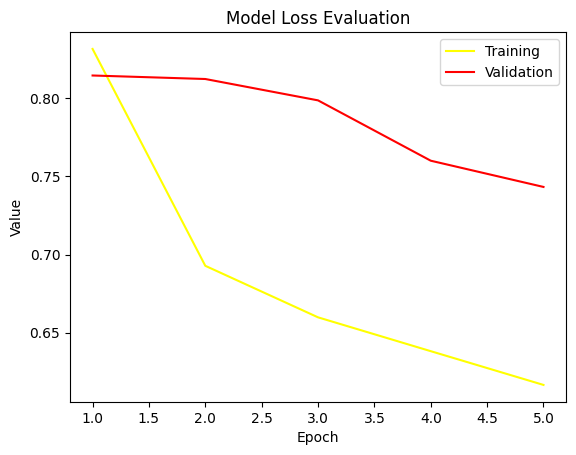

In [28]:
plt.plot(epoch_rng, metrics["train"]["loss"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["loss"], label="Validation", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Loss Evaluation")
plt.legend()
plt.show()

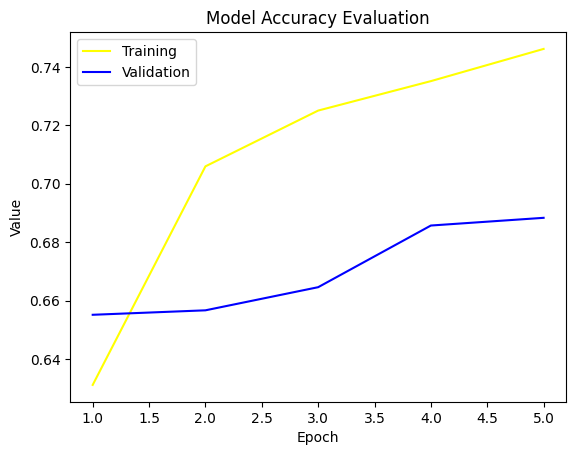

In [29]:
plt.plot(epoch_rng, metrics["train"]["accuracy"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["accuracy"], label="Validation", color="blue")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Accuracy Evaluation")
plt.legend()
plt.show()

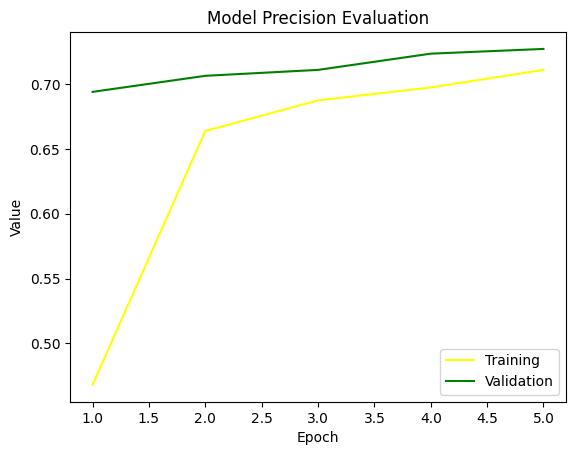

In [30]:
plt.plot(epoch_rng, metrics["train"]["precision"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["precision"], label="Validation", color="green")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Precision Evaluation")
plt.legend()
plt.show()

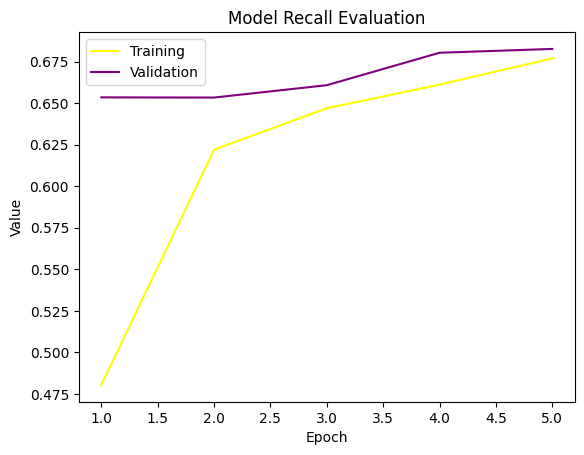

In [31]:
plt.plot(epoch_rng, metrics["train"]["recall"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["recall"], label="Validation", color="purple")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Recall Evaluation")
plt.legend()
plt.show()

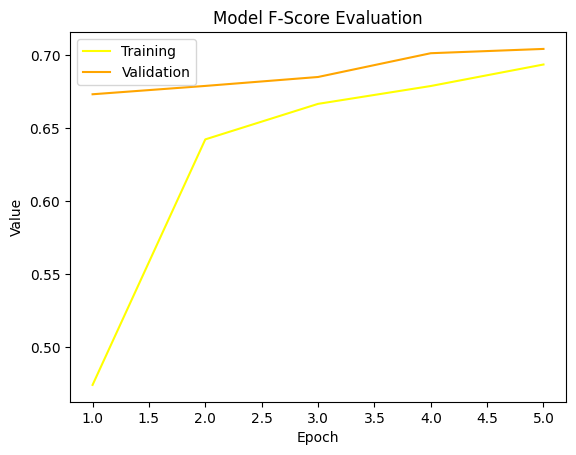

In [32]:
plt.plot(epoch_rng, metrics["train"]["f1_score"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["f1_score"], label="Validation", color="orange")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model F-Score Evaluation")
plt.legend()
plt.show()